<a href="https://colab.research.google.com/github/wendianaxu/speech-emotion-recognition/blob/main/training_more_nmfcc.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
import librosa
import os
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!git clone https://github.com/wendianaxu/speech-emotion-recognition.git

Cloning into 'speech-emotion-recognition'...
remote: Enumerating objects: 1534, done.
remote: Counting objects: 100% (65/65), done.
remote: Compressing objects: 100% (50/50), done.
remote: Total 1534 (delta 27), reused 31 (delta 9), pack-reused 1469
Receiving objects: 100% (1534/1534), 213.97 MiB | 23.66 MiB/s, done.
Resolving deltas: 100% (266/266), done.
Updating files: 100% (1447/1447), done.


In [6]:
# copy directory to drive
!cp -r "/content/speech-emotion-recognition" "/content/drive/MyDrive"

^C


In [13]:
# test: load an audio file, extract mfccs, and visualize

test_file = "/content/drive/MyDrive/speech-emotion-recognition/RAVDESS_data/Actor_01/03-01-01-01-01-01-01.wav"
n_mfcc = 30 # common choice
sr = 22050 # sampling rate


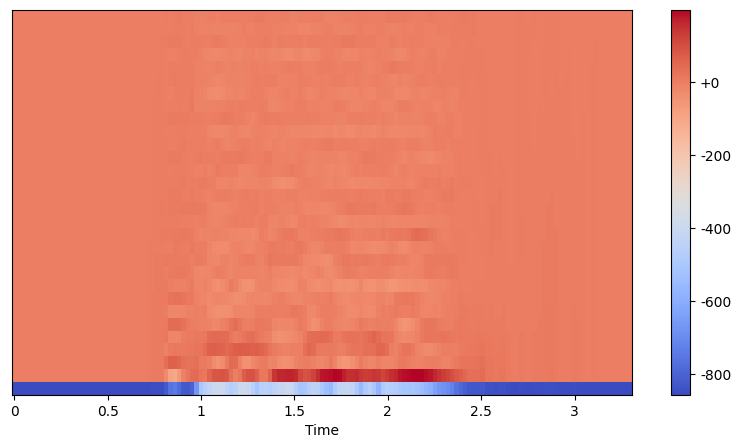

In [8]:
# visualize mfccs
audio, sampling_rate = librosa.load(test_file, sr=sr, duration=None)
test_mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

plt.figure(figsize=(10, 5))
librosa.display.specshow(test_mfccs, 
                         x_axis="time", 
                         sr=sr)
plt.colorbar(format="%+2.f")
plt.show()

In [9]:
# function for loading an audio file
data_path = "/content/speech-emotion-recognition/RAVDESS_data/"
def load_file(path):
  '''
  Load one audio file and return a 1D array containing its mfccs averaged across time
  '''
  audio, sampling_rate = librosa.load(path, sr=sr, duration=None)
  mfccs = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc) # extract MFCC matrix (cols = coefficients, rows = time)
  features = np.mean(mfccs.T, axis=0)  # condense MFCC matrix into 1D array, averaging each coefficient across time
  return features

#load_file(test_file)


In [10]:
# function for transforming dataset into arrays
def preprocess_data(path):
  '''
  Preprocess data in all folders within the dataset. 
  '''
  X = []
  y = []
  for folder in os.listdir(path): # each folder = one actor
      for file in os.listdir(os.path.join(path, folder)):
          if file.endswith('.wav'):
              emotion = file.split('-')[2] # get emotion label
              if int(emotion) == 1:
                  label = 'Neutral'
              elif int(emotion) == 2:
                  label = 'Calm'
              elif int(emotion) == 3:
                  label = 'Happy'
              elif int(emotion) == 4:
                  label = 'Sad'
              elif int(emotion) == 5:
                  label = 'Angry'
              elif int(emotion) == 6:
                  label = 'Fearful'
              elif int(emotion) == 7:
                  label = 'Disgust'
              elif int(emotion) == 8:
                  label = 'Surprised'
              else:
                  label = 'UNK'
                  
              file_path = os.path.join(path, folder, file)
              features = load_file(file_path)
              X.append(features)
              y.append(label)
  return np.array(X), np.array(y)


In [16]:
X, y = preprocess_data(data_path)
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (1440, 30)
Shape of y: (1440,)


In [74]:
# function that visualizes different emotions for one statement, given that intensity, repetition, and actor are all same
def visualize_by_statement(path, intensity='01', repetition='01', actor='01'):
    emo = ['Neutral', 'Calm', 'Happy', 'Sad', 'Angry', 'Fearful', 'Disgust', 'Surprised', 'UNK']
    color_arr = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan', 'magenta']
    x_values = range(n_mfcc)

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))

    for file in os.listdir(os.path.join(path, 'Actor_'+ actor)):
        if file.split('-')[3] == intensity and file.split('-')[5] == repetition:
            emotion = file.split('-')[2]  # get emotion label
            mfcc = load_file(os.path.join(path, 'Actor_'+ actor, file))

            # Plot all emotions in both subplots
            for ax in axes:
                ax.scatter(x_values, mfcc, color=color_arr[int(emotion) - 1], label=emo[int(emotion) - 1])

    for i, ax in enumerate(axes):
        # ax.set_title(f'Subplot {i+1}')
        ax.set_xlabel('Features')
        ax.set_ylabel('MFCC Values')

        if i == 0:
            ax.set_ylim(-800, 100)
        else:
            ax.set_ylim(-20, 40)

        # Remove duplicate labels from the legend
        handles, labels = ax.get_legend_handles_labels()
        by_label = dict(zip(labels, handles))
        ax.legend(by_label.values(), by_label.keys())

    plt.tight_layout()
    plt.show()

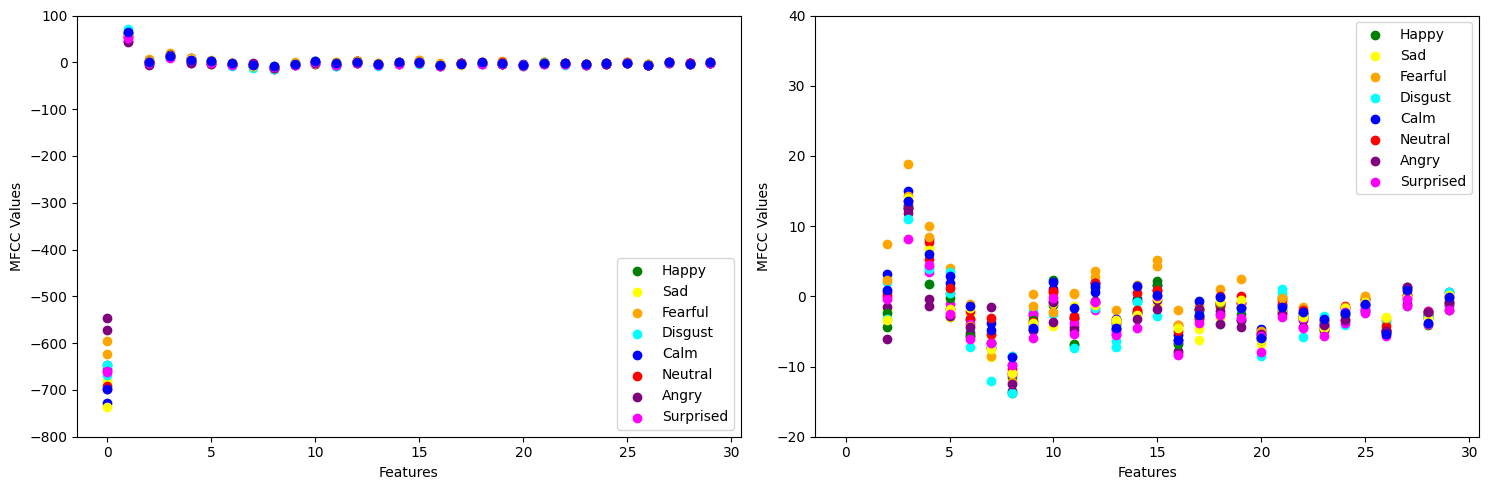

In [75]:
visualize_by_statement(data_path, intensity='01', repetition='01', actor='01')

In [17]:
# save X, y
np.save('/content/drive/MyDrive/speech-emotion-recognition/X.npy', X)
np.save('/content/drive/MyDrive/speech-emotion-recognition/y.npy', y)

In [18]:
# load X, y
X = np.load('/content/drive/MyDrive/speech-emotion-recognition/X.npy')
y = np.load('/content/drive/MyDrive/speech-emotion-recognition/y.npy')
print(X.shape, y.shape)

(1440, 30) (1440,)


In [22]:
# one-hot encode labels
from sklearn.preprocessing import OneHotEncoder
OHE = OneHotEncoder()

y = np.array(y).reshape(-1,1)
y = OHE.fit_transform(y).toarray()

In [23]:
# train-test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0)

In [24]:
# CNN with torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio
from torchsummary import summary
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [25]:
# transform preprocessed data to Dataset class
from torch.utils.data import TensorDataset, DataLoader
from torch import Tensor

# transform arrays to torch tensors
X_train = Tensor(X_train).unsqueeze(1)
y_train = Tensor(y_train)
X_test = Tensor(X_test).unsqueeze(1)
y_test = Tensor(y_test)

train_set = TensorDataset(X_train, y_train) 
test_set = TensorDataset(X_test, y_test) 


In [26]:
X_test.shape

torch.Size([288, 1, 30])

In [27]:
# create DataLoaders
batch_size = 16

train_loader = DataLoader(train_set, batch_size = batch_size, 
                          shuffle = True, num_workers = 2)
test_loader = DataLoader(test_set, batch_size = batch_size, 
                          shuffle = True, num_workers = 2)

In [39]:
# training loop
import torch.optim as optim

def train(model, k_epochs = 1, print_every = 20):

    loss_fn = nn.CrossEntropyLoss() 
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    correct, total = 0, 0

    for epoch in range(k_epochs): 

        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):

            # extract a batch of training data from the data loader
            X, y = data
            X = X.to(device)
            y = y.to(device)

            # zero out gradients: we're going to recompute them in a moment
            optimizer.zero_grad()

            # compute the loss (forward pass)
            y_hat = model(X)
            loss = loss_fn(y_hat, y)

            # compute the gradient (backward pass)
            loss.backward()

            # Adam uses the gradient to update the parameters
            optimizer.step()

            # print statistics
            running_loss += loss.item()

            # for printing accuracy
            total += y.size(0)
            correct += (torch.argmax(y_hat, dim=1) == torch.argmax(y, dim=1)).sum().item()
            # correct += (torch.argmax(y_hat, dim=1) == y).sum().item()


            # print the epoch, number of batches processed, and running loss 
            # in regular intervals
            if i % print_every == print_every - 1:    
              print(f'[epoch: {epoch + 1}, batches: {i + 1:5d}], loss: {running_loss / print_every:.3f}, accuracy:{correct/total:.3f}')
              running_loss = 0.0

    print('Finished Training')



In [30]:
# testing loop
def test(model, data_loader):
    correct = 0
    total = 0
    # torch.no_grad creates an environment in which we do NOT store the 
    # computational graph. We don't need to do this because we don't care about 
    # gradients unless we're training
    with torch.no_grad():
        for data in data_loader:
            X, y = data
            X = X.to(device)
            y = y.to(device)
            
            # run all the images through the model
            y_hat = model(X)

            # the class with the largest model output is the prediction
            predicted = torch.argmax(y_hat, dim=1)

            # compute the accuracy
            total += y.size(0)
            correct += (predicted == torch.argmax(y, dim=1)).sum().item()

    print(f'Test accuracy: {100 * correct // total} %')


In [37]:
# model1
class ConvNet(nn.Module):
    def __init__(self, input_len):
        super().__init__()

        self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
        self.bn1 = nn.BatchNorm1d(32)
        self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
        self.bn2 = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(2)
        self.fc1 = nn.Linear(64 * (((input_len - 2) // 2 - 2) // 2), 128)
        self.fc2 = nn.Linear(128, 8)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_len = 30  # input_len is the n_mfcc
model1 = ConvNet(input_len).to(device)

In [40]:
# train model1
train(model1, k_epochs = 50)

[epoch: 1, batches:    20], loss: 2.054, accuracy:0.191
[epoch: 1, batches:    40], loss: 1.920, accuracy:0.225
[epoch: 1, batches:    60], loss: 1.923, accuracy:0.224
[epoch: 2, batches:    20], loss: 1.786, accuracy:0.252
[epoch: 2, batches:    40], loss: 1.814, accuracy:0.259
[epoch: 2, batches:    60], loss: 1.705, accuracy:0.276
[epoch: 3, batches:    20], loss: 1.600, accuracy:0.299
[epoch: 3, batches:    40], loss: 1.621, accuracy:0.310
[epoch: 3, batches:    60], loss: 1.656, accuracy:0.316
[epoch: 4, batches:    20], loss: 1.548, accuracy:0.327
[epoch: 4, batches:    40], loss: 1.587, accuracy:0.333
[epoch: 4, batches:    60], loss: 1.577, accuracy:0.339
[epoch: 5, batches:    20], loss: 1.483, accuracy:0.351
[epoch: 5, batches:    40], loss: 1.504, accuracy:0.356
[epoch: 5, batches:    60], loss: 1.429, accuracy:0.363
[epoch: 6, batches:    20], loss: 1.412, accuracy:0.374
[epoch: 6, batches:    40], loss: 1.356, accuracy:0.381
[epoch: 6, batches:    60], loss: 1.383, accurac

In [41]:
# test model1
test(model1, test_loader)

Test accuracy: 66 %


In [43]:
# model2
class ConvNet(nn.Module):
  def __init__(self, input_len):
    super().__init__()

    self.conv1 = nn.Conv1d(1, 32, kernel_size=3)
    self.bn1 = nn.BatchNorm1d(32)
    self.conv2 = nn.Conv1d(32, 64, kernel_size=3)
    self.bn2 = nn.BatchNorm1d(64)
    self.pool = nn.MaxPool1d(2)
    self.fc1 = nn.Linear(64 * (((input_len - 2) // 2 - 2) // 2), 32)
    self.fc2 = nn.Linear(32, 16)
    self.fc3 = nn.Linear(16, 8)
  
  def forward(self, x):
    x = self.pool(F.relu(self.bn1(self.conv1(x))))
    x = self.pool(F.relu(self.bn2(self.conv2(x))))
    x = torch.flatten(x, 1) 
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return x

input_len = 30
model2 = ConvNet(input_len).to(device)

In [44]:
train(model2, k_epochs = 50)

[epoch: 1, batches:    20], loss: 2.066, accuracy:0.166
[epoch: 1, batches:    40], loss: 2.044, accuracy:0.180
[epoch: 1, batches:    60], loss: 2.033, accuracy:0.180
[epoch: 2, batches:    20], loss: 1.980, accuracy:0.187
[epoch: 2, batches:    40], loss: 1.932, accuracy:0.196
[epoch: 2, batches:    60], loss: 1.920, accuracy:0.203
[epoch: 3, batches:    20], loss: 1.882, accuracy:0.211
[epoch: 3, batches:    40], loss: 1.868, accuracy:0.212
[epoch: 3, batches:    60], loss: 1.870, accuracy:0.220
[epoch: 4, batches:    20], loss: 1.791, accuracy:0.233
[epoch: 4, batches:    40], loss: 1.766, accuracy:0.240
[epoch: 4, batches:    60], loss: 1.802, accuracy:0.247
[epoch: 5, batches:    20], loss: 1.730, accuracy:0.256
[epoch: 5, batches:    40], loss: 1.711, accuracy:0.261
[epoch: 5, batches:    60], loss: 1.659, accuracy:0.268
[epoch: 6, batches:    20], loss: 1.594, accuracy:0.281
[epoch: 6, batches:    40], loss: 1.631, accuracy:0.286
[epoch: 6, batches:    60], loss: 1.579, accurac

In [47]:
test(model2, test_loader)

Test accuracy: 56 %


In [55]:
# model 3
class EmotionClassifierCNN(nn.Module):
    def __init__(self, num_classes, input_len):
        super(EmotionClassifierCNN, self).__init__()
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm1d(16)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm1d(32)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm1d(64)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2, padding=0)
        
        output_size = input_len // (2 * 2 * 2)  # Divide by 2 for each pooling layer
        self.fc1 = nn.Linear(64 * output_size, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.pool1(F.relu(self.bn1(self.conv1(x))))
        x = self.pool2(F.relu(self.bn2(self.conv2(x))))
        x = self.pool3(F.relu(self.bn3(self.conv3(x))))
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_len = X_train.shape[2]
num_classes = y_train.shape[1]
model3 = EmotionClassifierCNN(num_classes, input_len).to(device)
# print(model3)

In [56]:
train(model3, k_epochs = 50)

[epoch: 1, batches:    20], loss: 2.083, accuracy:0.138
[epoch: 1, batches:    40], loss: 2.002, accuracy:0.175
[epoch: 1, batches:    60], loss: 1.944, accuracy:0.202
[epoch: 2, batches:    20], loss: 1.844, accuracy:0.227
[epoch: 2, batches:    40], loss: 1.816, accuracy:0.241
[epoch: 2, batches:    60], loss: 1.875, accuracy:0.246
[epoch: 3, batches:    20], loss: 1.767, accuracy:0.260
[epoch: 3, batches:    40], loss: 1.718, accuracy:0.267
[epoch: 3, batches:    60], loss: 1.767, accuracy:0.271
[epoch: 4, batches:    20], loss: 1.698, accuracy:0.278
[epoch: 4, batches:    40], loss: 1.639, accuracy:0.283
[epoch: 4, batches:    60], loss: 1.656, accuracy:0.292
[epoch: 5, batches:    20], loss: 1.629, accuracy:0.299
[epoch: 5, batches:    40], loss: 1.664, accuracy:0.302
[epoch: 5, batches:    60], loss: 1.552, accuracy:0.308
[epoch: 6, batches:    20], loss: 1.606, accuracy:0.313
[epoch: 6, batches:    40], loss: 1.653, accuracy:0.315
[epoch: 6, batches:    60], loss: 1.566, accurac

In [57]:
test(model3, test_loader)

Test accuracy: 62 %
